# Выбор локации для скважины

# Содержание
1. [Загрузка и подготовка данных](#Загрузка-и-подготовка-данных)
2. [Обучение и проверка модели](#Обучение-и-проверка-модели)
3. [Подготовка к расчёту прибыли](#Подготовка-к-расчёту-прибыли)
4. [Расчёт прибыли и рисков](#Расчёт-прибыли-и-рисков)
5. [Общий вывод](#Общий-вывод)

# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Установка библиотек

In [2]:
!pip install phik -q

# Импортирование библиотек и создание констант 

In [62]:
import numpy as np
import phik
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

RANDOM_STATE = 42
TEST_SIZE = 0.25

warnings.filterwarnings('ignore')

# Методы для работы

**Метод для построения диаграмм**

In [4]:
def create(data, column, type, bins = 100, color = 'blue', alpha = 0.5, edge_color='black', edge_width=1.2, rotation = 45):
    category_counts = data[column].value_counts()
    if type == "hist":
        """
        Создает гистограмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(12, 6))
        plt.hist(data=data, x=column, bins=bins, color=color, alpha=alpha, edgecolor=edge_color, linewidth=edge_width)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Призак {column} - Частота распределения', fontsize=18)
        plt.grid(True)
        plt.show()
    elif type == "barplot":
        """
        Создает столбчатую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.xticks(rotation=rotation)
        new_data = data[column].value_counts()
        df_new_data = new_data.reset_index()
        df_new_data.columns = [column, 'count']

        sns.barplot(x=column, y='count', data = df_new_data)
        plt.title(f'{column}.Частота распределения')
        plt.xlabel(f'{column}')
        plt.ylabel(f'количество {column}')
    elif type == "pie":
        """
        Создает круговую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Круговая диаграмма для {column}', fontsize=18)
        plt.show()
    elif type == "boxplot":
        """
        Создает ящик с усами для заданного столбца DataFrame.
        """
        plt.figure(figsize=(10, 6))
        plt.boxplot(data[column], notch=True, patch_artist=True, boxprops=dict(facecolor=color, color=edge_color), 
                    whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), 
                    medianprops=dict(color=edge_color), flierprops=dict(markeredgecolor=edge_color, markerfacecolor=color))
        plt.xlabel(column)
        plt.title(f'Ящик с усами для признака {column}', fontsize=18)
        plt.grid(True)
        plt.show()

**Метод для построения phik матрицы**

In [5]:
def create_phik(data, cols):
    corr_matrix = data.phik_matrix(interval_cols = cols)
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='Greens')
    plt.title('Phik')
    plt.show()

**Метод для обучения модели**

In [6]:
def train_and_evaluate(data):
    # Разделение данных на признаки и целевую переменную
    X = data.drop(['product'], axis=1)
    y = data['product']
    
    # Разделение на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

    # Обучение модели
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Предсказания на валидационной выборке
    predictions = model.predict(X_valid)

    # Расчет среднего запаса предсказанного сырья и RMSE
    mean_product = predictions.mean()
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))

    return predictions, y_valid, mean_product, rmse

## Загрузка и подготовка данных

In [7]:
try:
    df_geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    print('Что-то пошло не так')

### Загрузка данных

**Датасет df_geo_data_0**

In [8]:
display(df_geo_data_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [9]:
display(df_geo_data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Датасет df_geo_data_1**

In [10]:
display(df_geo_data_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [11]:
display(df_geo_data_1.tail())

,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


**Датасет df_geo_data_2**

In [12]:
display(df_geo_data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [13]:
display(df_geo_data_2.sample(5))

,id,f0,f1,f2,product
80118,bhNUd,-3.411981,1.125454,1.787764,90.832738
60509,uqS33,0.580056,-0.633715,3.726990,130.745920
57285,s0HzN,-0.301129,1.121563,2.356438,52.002509
49883,BUQ2Z,-0.255301,-3.370848,-1.287123,77.558270
11198,w7HnZ,1.562576,1.743211,0.607222,50.736100


**Описание данных**

* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

**Вывод по загрузке данных**


**Датасеты:**
* Данные геологоразведки в первом регионе: df_geo_data_0
* Данные геологоразведки во втором регионе: df_geo_data_1
* Данные геологоразведки в третьем регионе: df_geo_data_2

**Изучение датасетов:**
1. В датасетах отсутствуют пропуски
2. Типы данных корректны во всех трех датасетах. 
3. Возможно наличие дубликатов.

### Предобработка данных

*Создадим список датафреймов:*

In [14]:
data_frames = [df_geo_data_0, df_geo_data_1, df_geo_data_2]

**Обработка дубликатов**

In [15]:
for data in data_frames: 
    data_name = [key for key, value in locals().items() if value is data][0]
    if data.duplicated(subset = data.columns).sum() > 0:
        display(data[data.duplicated()])
    else:
        print(f'Дубликаты в {data_name} отсутствуют')

Дубликаты в df_geo_data_0 отсутствуют
Дубликаты в df_geo_data_1 отсутствуют
Дубликаты в df_geo_data_2 отсутствуют


Явных дубликатов не обнаружено, проверим наличие дубликатов по столбцу id.

*Датасет df_geo_data_0*

In [16]:
display(df_geo_data_0[df_geo_data_0.duplicated(subset = ['id'])])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


*Датасет df_geo_data_1*

In [17]:
display(df_geo_data_1[df_geo_data_1.duplicated(subset = ['id'])])

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


*Датасет df_geo_data_2*

In [18]:
display(df_geo_data_2[df_geo_data_2.duplicated(subset = ['id'])])

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Дубликатов по id совсем немного, оставим их.

Столбец id можем удалить, он не пригодится в дальнейшем.

In [19]:
df_geo_data_0 = df_geo_data_0.drop('id', axis = 1)
df_geo_data_1 = df_geo_data_1.drop('id', axis = 1)
df_geo_data_2 = df_geo_data_2.drop('id', axis = 1)

data_frames = [df_geo_data_0, df_geo_data_1, df_geo_data_2]

for data in data_frames:
    print(data.columns)

Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


**Вывод по предобработке данных**

В датасетах не наблюдается явных дубликатов, но есть небольшое количество неявных, оставим их.

Столбец id был удалён во всех трёх датасетах.

### Исследовательский анализ данных

*Датасет df_geo_data_0*

In [20]:
display(df_geo_data_0.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**Признак 'f0'**

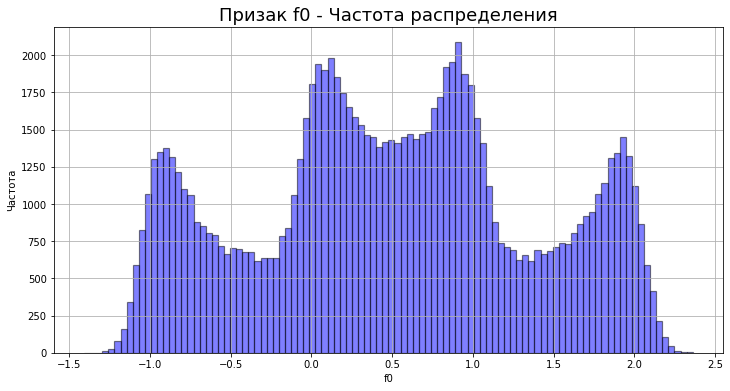

In [21]:
create(df_geo_data_0, 'f0', 'hist')

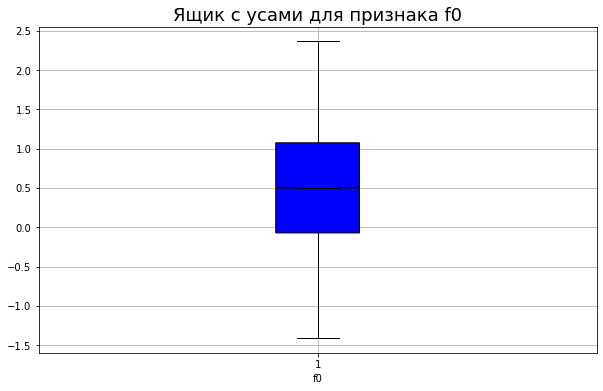

In [22]:
create(df_geo_data_0, 'f0', 'boxplot')

**Анализ гистограммы**

Наблюдается мультимодальное распределение с несколькими пиками. Заметные пики распределения приходятся примерно на значения -0.75, 0.2, 0.9

**Анализ "ящика с усами"**

На диаграмме "ящик с усами" видно, что медиана признака f0 находится около 0.5, а 25-й и 75-й перцентили располагаются в пределах от 0 до 1. Это указывает на то, что большая часть данных сосредоточена в этом диапазоне. Отсутствие явных выбросов говорит о том, что данные относительно однородны и нет экстремальных значений, сильно отклоняющихся от основной массы данных.

**Признак 'f1'**

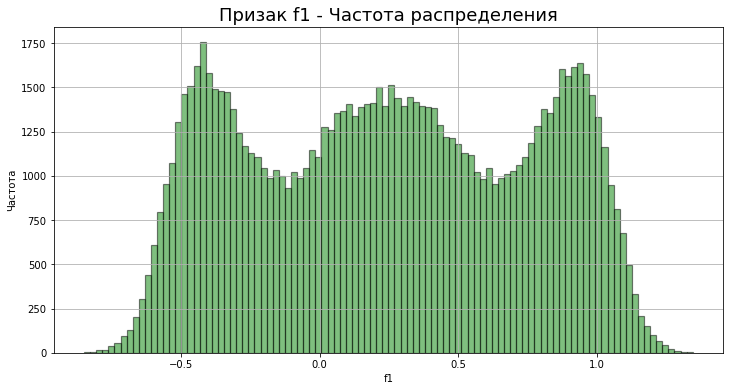

In [23]:
create(df_geo_data_0, 'f1', 'hist', color = 'green')

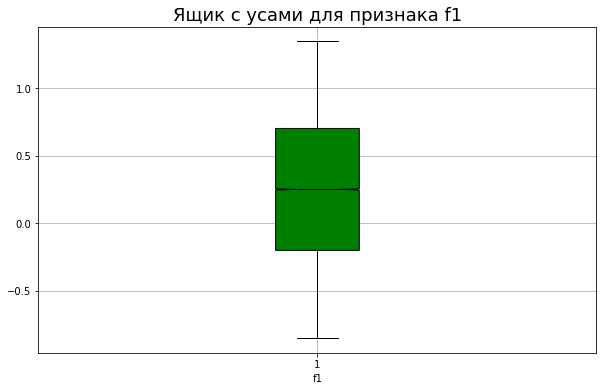

In [24]:
create(df_geo_data_0, 'f1', 'boxplot', color = 'green')

**Анализ гистограммы**

Распределение представляет собой мультимодальное распределение с несколькими пиками. Заметные пики распределения приходятся примерно на значения -0.4, 0.25, 0.9

**Анализ "ящика с усами"**

На диаграмме "ящик с усами" видно, что медианное значение признака f1 близко к 0.25, что соответствует середине между двумя пиками, наблюдаемыми на гистограмме. Первый и третий квартили находятся в интервале примерно от -0.1 до 0.5. Выбросы отсутствуют.

**Признак 'f2'**

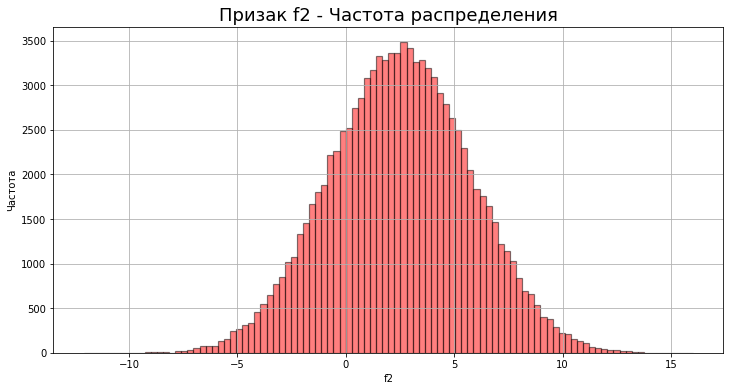

In [25]:
create(df_geo_data_0, 'f2', 'hist', color = 'red')

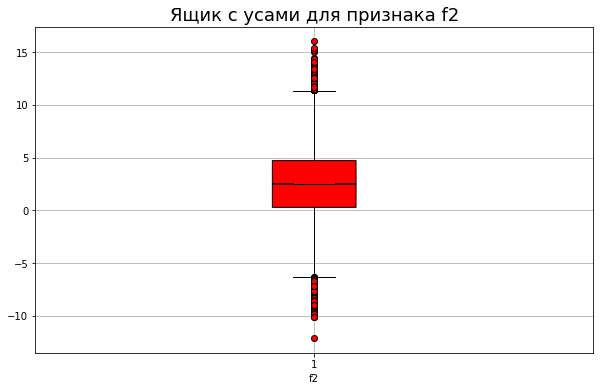

In [26]:
create(df_geo_data_0, 'f2', 'boxplot', color = 'red')

**Анализ гистограммы**

Гистограмма частот распределения признака f2 показывает классическую форму колокола, которая соответствует нормальному распределению. Большинство значений признака сосредоточено вокруг центра, что указывает на симметричность распределения вокруг среднего значения. Отсутствие длинных "хвостов" говорит о том, что экстремальные значения признака встречаются реже, чем остальные.

**Анализ "ящика с усами"**

На диаграмме "ящик с усами" видно, что медиана признака f2 находится около 2.5, а квартили располагаются симметрично относительно неё. Это подтверждает наблюдения, сделанные на гистограмме, о нормальности распределения. Однако, присутствуют некоторые выбросы.

**Признак 'product'**

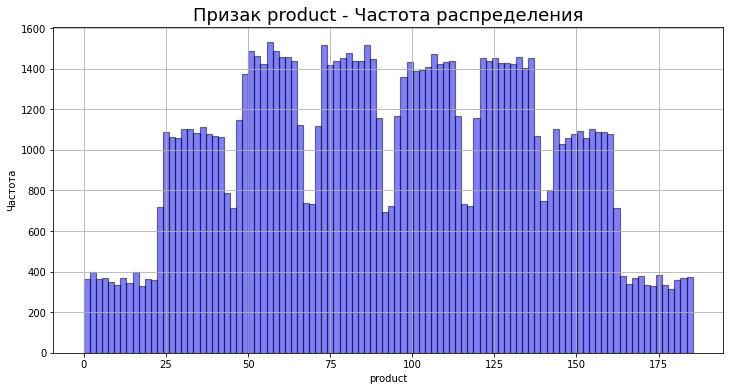

In [27]:
create(df_geo_data_0, 'product', 'hist')

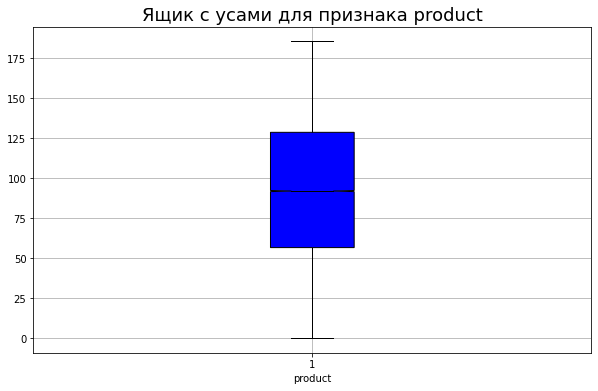

In [28]:
create(df_geo_data_0, 'product', 'boxplot')

**Анализ гистограммы**

Распределение имеет несколько пиков, которые похожи на группы с различными частотами.

**Анализ "ящика с усами"**

На диаграмме "ящик с усами" видно, что медиана распределения признака product находится в районе 85. "Ящик" показывает интерквартильный размах (расстояние между первым и третьим квартилями), который сосредоточен вокруг медианы, и усы, которые простираются до наиболее экстремальных значений без выбросов.

*Датасет df_geo_data_1*

In [29]:
display(df_geo_data_1.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


**Признак 'f0'**

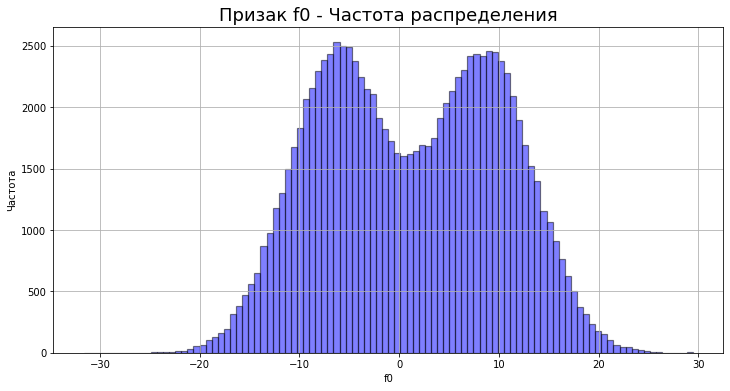

In [30]:
create(df_geo_data_1, 'f0', 'hist')

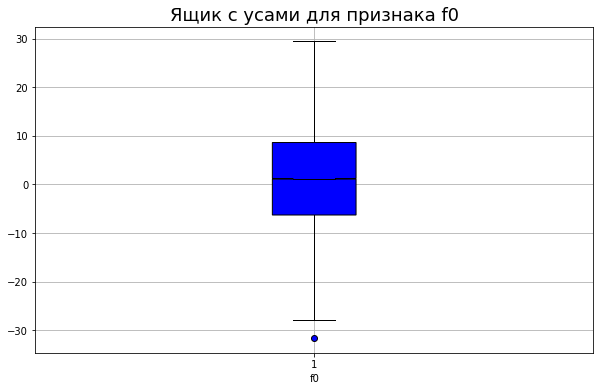

In [31]:
create(df_geo_data_1, 'f0', 'boxplot')

**Анализ гистограммы**

На гистограмме представлено распределение признака f0, которое образует два выраженных пика примерно при значениях -6 и 10. Такое распределение может указывать на двухмодальную природу данных.

**Анализ "ящика с усами"**

Диаграмма "ящик с усами" для признака f0 показывает, что медиана близка к нулю, и большая часть данных сосредоточена в интервале от -6 до 10, что соответствует пикам на гистограмме. "Усы" диаграммы тянутся далеко за пределы квартилей, указывая на наличие значений вне основного распределения. Однако, существует всего один значительный выброс. Это может быть аномалией или ошибкой в данных.

**Признак 'f1'**

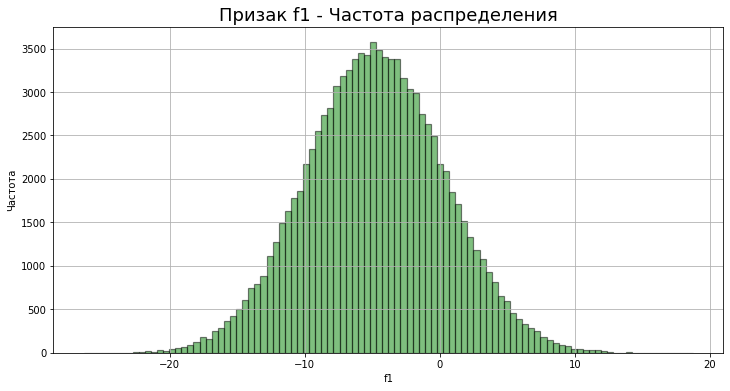

In [32]:
create(df_geo_data_1, 'f1', 'hist', color = 'green')

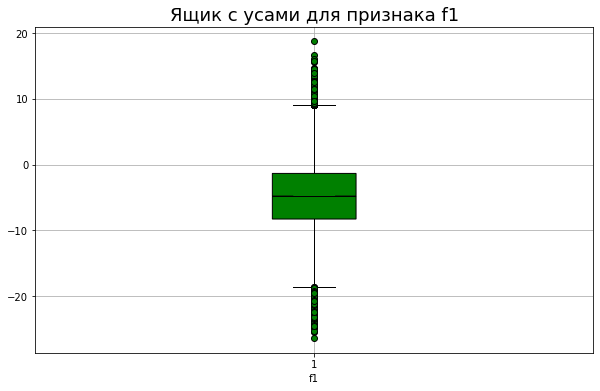

In [33]:
create(df_geo_data_1, 'f1', 'boxplot', color = 'green')

**Анализ гистограммы**

Гистограмма частот распределения признака f1 представляет собой форму, характерную для нормального распределения, с одним центральным пиком около -5. Распределение симметрично относительно своего центра, что указывает на отсутствие смещения в данных.

**Анализ "ящика с усами"**

Диаграмма "ящика с усами" для признака f1 подтверждает, что большая часть данных сконцентрирована около медианы, которая находится близко к нулю. Интерквартильный размах (расстояние между 25-м и 75-м перцентилями) относительно узкий, что говорит о том, что большая часть значений признака находится вблизи медианы. Присутствуют выбросы.

**Признак 'f2'**

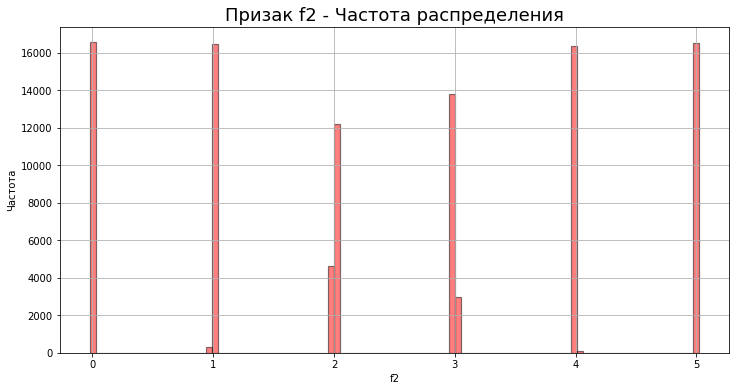

In [34]:
create(df_geo_data_1, 'f2', 'hist', color = 'red')

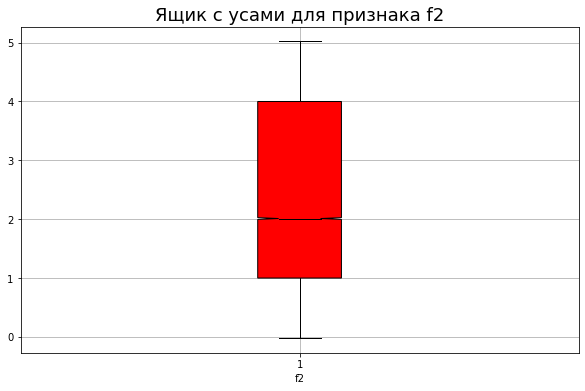

In [35]:
create(df_geo_data_1, 'f2', 'boxplot', color = 'red')

**Анализ гистограммы**

Гистограмма признака f2 показывает распределение с явными отдельными столбцами, что указывает на дискретное распределение данных. Значения признака f2 сконцентрированы вокруг определённых числовых категорий (в данном случае целых чисел от 0 до 5), и каждая категория имеет похожую частоту встречаемости.

**Анализ "ящика с усами"**

Диаграмма "ящик с усами" показывает, что медианный показатель признака f2 находится около значения 2, и большинство данных находятся в диапазоне от 1 до 4. Отсутствие "усов" и выбросов за пределами этого диапазона подтверждает дискретный характер распределения и отсутствие аномальных значений за пределами основных категорий.

**Признак 'product'**

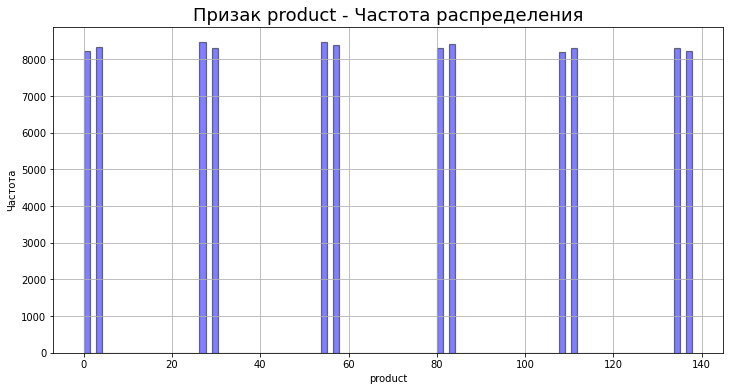

In [36]:
create(df_geo_data_1, 'product', 'hist')

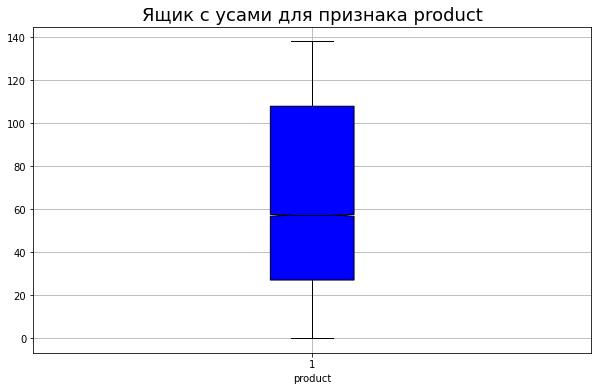

In [37]:
create(df_geo_data_1, 'product', 'boxplot')

**Анализ гистограммы**

Гистограмма признака product показывает частотное распределение с ярко выраженными и равномерно распределенными пиками, что указывает на равномерное распределение значений этого признака.

**Анализ "ящика с усами"**

Диаграмма "ящика с усами" для признака product показывает, что медианное значение расположено около 60. Выбросы отсутствуют.

*Датасет df_geo_data_2*

In [38]:
display(df_geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Признак 'f0'**

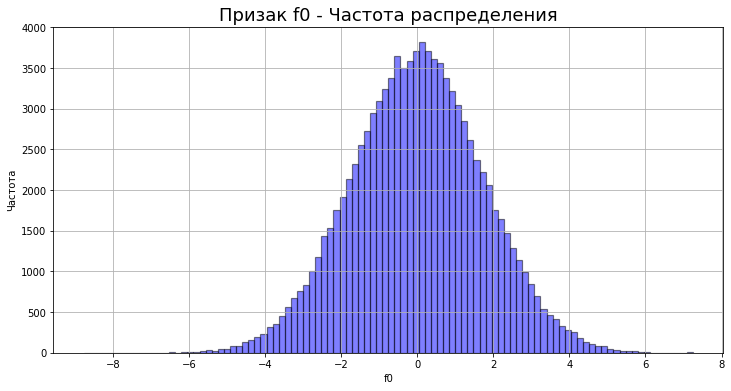

In [39]:
create(df_geo_data_2, 'f0', 'hist')

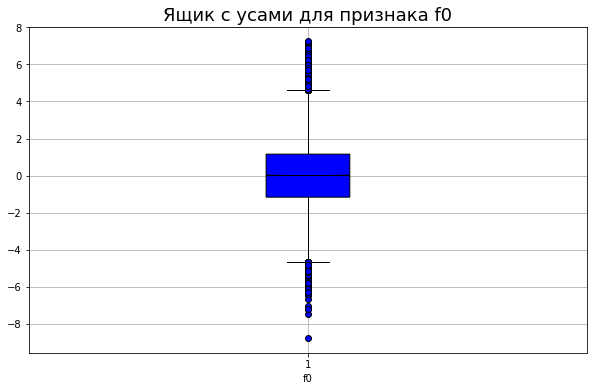

In [40]:
create(df_geo_data_2, 'f0', 'boxplot')

**Анализ гистограммы**

Гистограмма частот распределения признака f0 имеет форму, характерную для нормального распределения. Распределение симметрично относительно центра, который находится вблизи нуля.

**Анализ "ящика с усами"**

Диаграмма "ящика с усами" для признака f0 показывает, что медианное значение приближено к нулю, и большинство данных находятся в пределах от -1 до 1. Усы диаграммы простираются до значений примерно -5 и 5, но есть несколько выбросов за пределами этих значений. Тем не менее, их количество невелико по сравнению с общим количеством данных.

**Признак 'f1'**

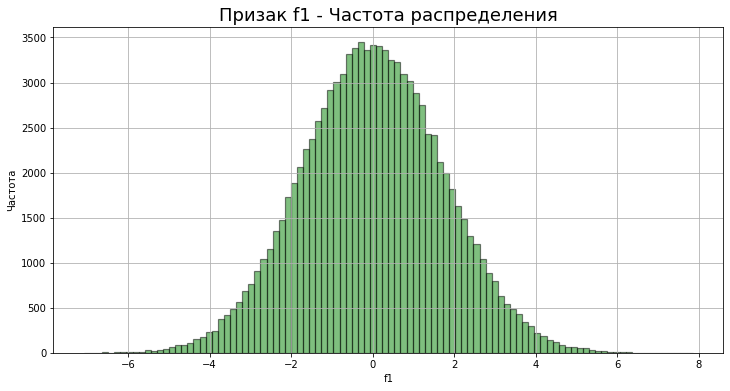

In [41]:
create(df_geo_data_2, 'f1', 'hist', color = 'green')

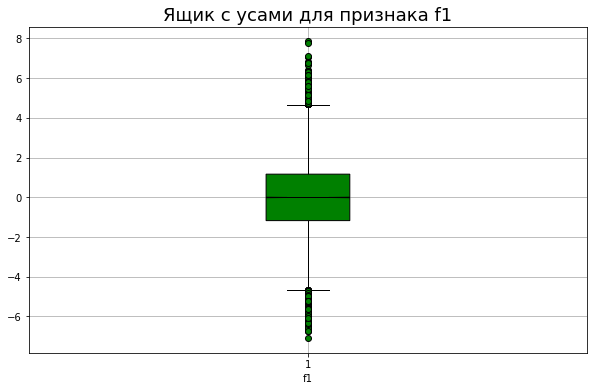

In [42]:
create(df_geo_data_2, 'f1', 'boxplot', color = 'green')

**Анализ гистограммы**

Гистограмма распределения признака f1 также напоминает нормальное распределение, с центром около нуля и убывающими частотами к краям диапазона.

**Анализ "ящика с усами"**

На диаграмме "ящика с усами" видно, что медиана признака f1 находится вблизи нуля, а квартили распределены симметрично относительно медианы. Усы простираются примерно до -6 и 6, что соответствует хвостам распределения на гистограмме. Количество выбросов не является необычным для нормального распределения.

**Признак 'f2'**

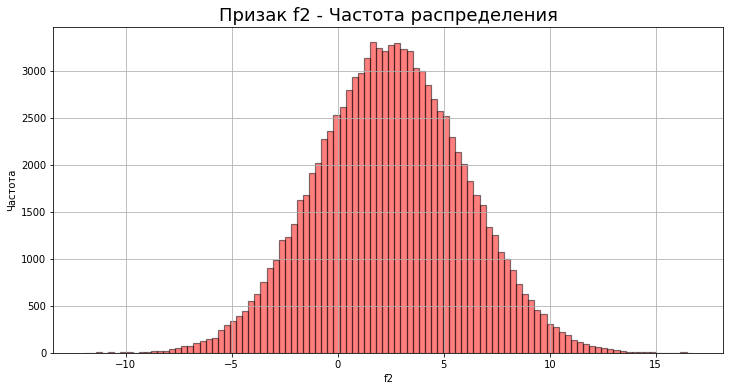

In [43]:
create(df_geo_data_2, 'f2', 'hist', color = 'red')

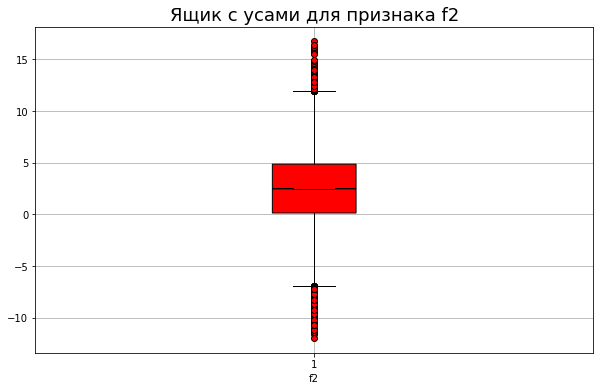

In [44]:
create(df_geo_data_2, 'f2', 'boxplot', color = 'red')

**Анализ гистограммы**

Гистограмма для признака f2 также имеет вид, напоминающий нормальное распределение.

**Анализ "ящика с усами"**

Диаграмма "ящика с усами" подтверждает, что медиана признака f2 близка к 2.5, и большая часть значений находится в интервале примерно от 0 до 5. Усы диаграммы простираются дальше, до значений около -8 и 8, что соответствует хвостам распределения. Выбросы могут указывать на наличие некоторых аномальных значений признака f2, однако их немного по сравнению с общим объёмом данных.

**Признак 'product'**

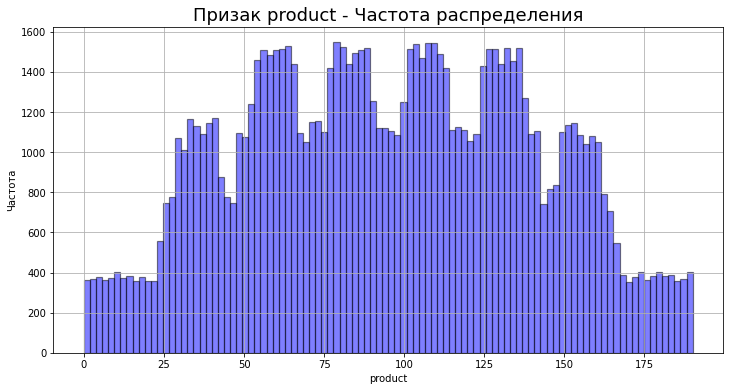

In [45]:
create(df_geo_data_2, 'product', 'hist')

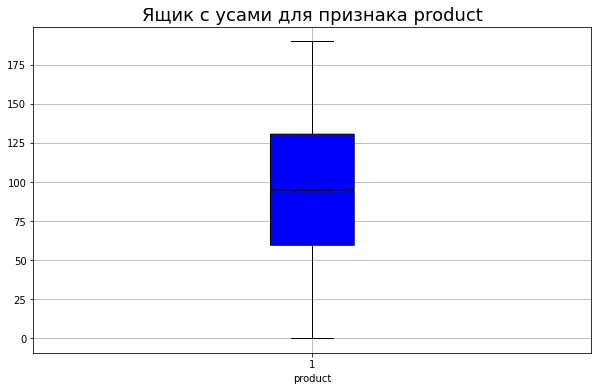

In [46]:
create(df_geo_data_2, 'product', 'boxplot')

**Анализ гистограммы**

Гистограмма признака product показывает неоднородное распределение с множественными пиками.

**Анализ "ящика с усами"**

На диаграмме "ящика с усами" видно, что медиана распределения признака product находится около значения 90. Выбросы отсутствуют.

**Вывод по исследовательскому анализу данных**

Большинство признаков имеют нормальное распределение. В даннных есть небольшие выбросы, но их лучше никак не убирать, поскольку в будущем может привести к недообучению модели.

### Корелляционный анализ

In [47]:
interval_cols = ['f0', 'f1', 'f2', 'product']

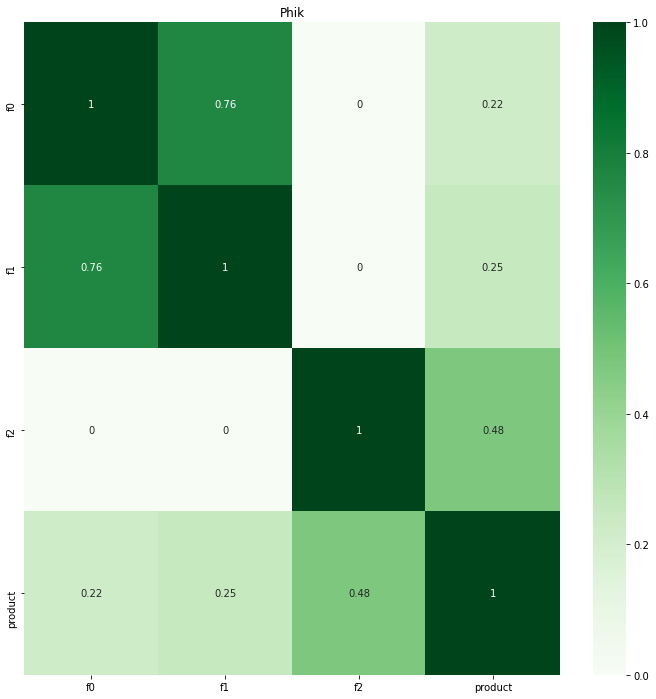

In [48]:
create_phik(df_geo_data_0, interval_cols)

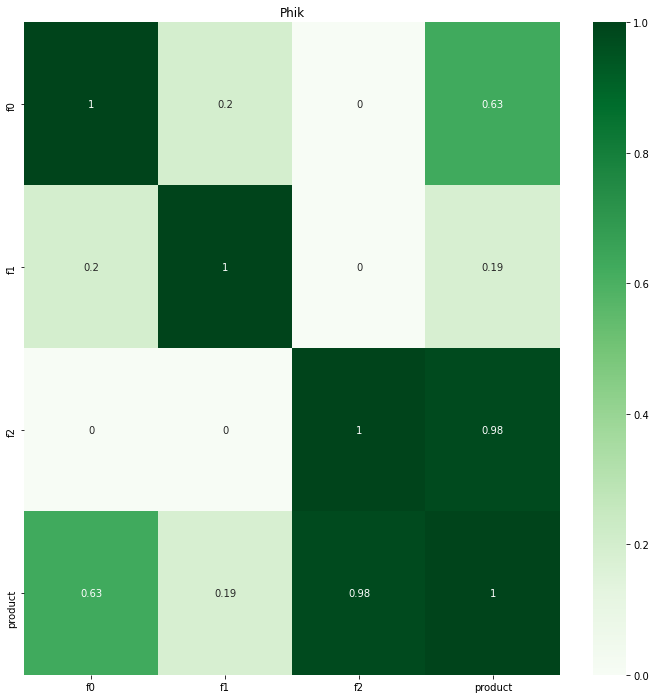

In [49]:
create_phik(df_geo_data_1, interval_cols)

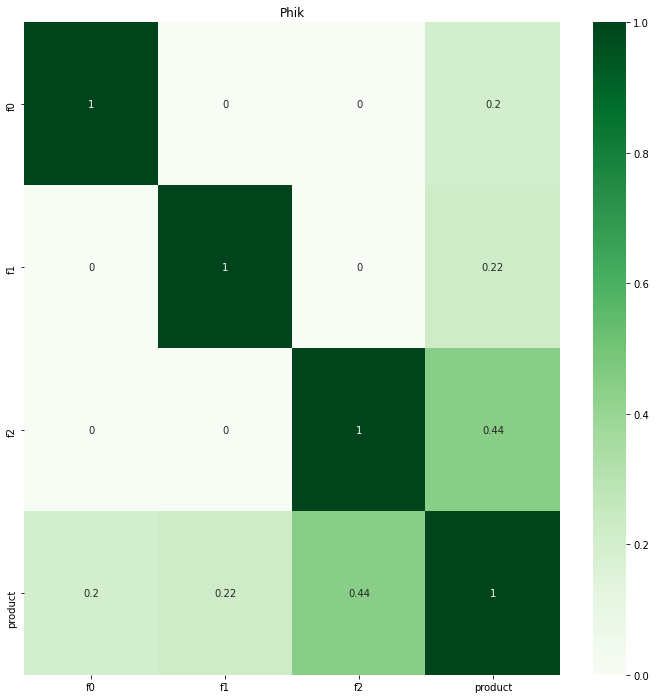

In [50]:
create_phik(df_geo_data_2, interval_cols)

**Вывод по корелляционному анализу**

Сильная корелляция наблюдается:
* В первой локации между признаками f0 и f1
* Во второй локации между признаками f2 и целевым признаком product

Средняя корелляция наблюдается:
* В первой локации между признаками f2 и целевым признаком product
* Во второй локации между признаками f0 и целевым признаком product
* В третьей локации между признаками f2 и целевым признаком product

Во остальных случаях наблюдается слабая корелляция или корелляции между признаками не наблюдается вообще

### Промежуточный вывод по загрузке и подготовке данных

**Загрузка данныых.**

Данные были успешно загружены.

Датасеты:
* Данные геологоразведки в первом регионе: df_geo_data_0
* Данные геологоразведки во втором регионе: df_geo_data_1
* Данные геологоразведки в третьем регионе: df_geo_data_2

Изучение датасетов:
1. В датасетах отсутствуют пропуски
2. Типы данных корректны во всех трех датасетах. 

**В результате предобработки данных:**
* В датасетах не обнаружено явных дубликатов, но обнаружено небольшое количество неявных, оставим их. 
* Столбец id был удалён во всех трёх датасетах.

**Исследовательский анализ данных показал:**
* Большинство признаков имеют нормальное распределение. 
* В даннных есть небольшие выбросы, но их лучше никак не убирать, поскольку в будущем может привести к недообучению модели.

**Корелляционный анализ данных показал:**

Сильная корелляция наблюдается:
* В первой локации между признаками f0 и f1
* Во второй локации между признаками f2 и целевым признаком product

## Обучение и проверка модели

### Обучение модели

In [51]:
results = {}
for i, data in enumerate([df_geo_data_0, df_geo_data_1, df_geo_data_2]):
    predictions, y_valid, mean_product, rmse = train_and_evaluate(data)
    results[f'geo_data_{i}'] = {
        'predictions': predictions,
        'actual': y_valid,
        'mean_product': mean_product,
        'rmse': rmse
    }

# Создание DataFrame для результатов
results_df = pd.DataFrame({
    'Регион': ['0', '1', '2'],
    'Предсказанное значение среднего запаса сырья': [results['geo_data_0']['mean_product'], 
                               results['geo_data_1']['mean_product'], 
                               results['geo_data_2']['mean_product']],
    'RMSE': [results['geo_data_0']['rmse'], 
             results['geo_data_1']['rmse'], 
             results['geo_data_2']['rmse']]
})


display(results_df.round(2))

,Регион,Предсказанное значение среднего запаса сырья,RMSE
0,0,92.59,37.58
1,1,68.73,0.89
2,2,94.97,40.03


### Промежуточный вывод по обучению модели

Суммарные значения предсказаний о количестве нефти примерно равны суммарным предсказанным значениям. Модель наиболее точно предсказала запасы нефти во втором наборе данных, где RMSE составил 0.88, затем следуют результаты для первого и третьего наборов данных соответственно.

## Подготовка к расчёту прибыли

Будем использовать следующие условные параметры:
* Бюджет на разработку: 10 млрд рублей
* При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выбираем 200 лучших для разработки.
* Доход с каждой единицы продукта: 450 тысяч рублей.

### Сохранение ключевых переменных

In [58]:
BUDGET = 10_000_000_000
REVENUE_PER_UNIT = 450_000
CHOSEN_POINTS = 500
BEST_POINTS = 200

### Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины

In [59]:
volume = BUDGET / (REVENUE_PER_UNIT * 200)
print('Достаточный объём сырья =', volume)

Достаточный объём сырья = 111.11111111111111


### Промежуточный вывод по подготовке к расчёту прибыли

Во всех трёх регионах средний запас сырья в скважинах меньше, чем требуемый объём для безубыточной работы (111.11 единиц).

Это указывает на потенциальные риски при разработке скважин в данных регионах, и необходимость дополнительного анализа для выбора наиболее перспективных скважин.

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [60]:
def income(predictions, target, point_best=200, income_per_product=450_000, budget=10e9):
    best_predict = predictions.sort_values(ascending=False).head(point_best)
    selected = target.iloc[best_predict.index]
    return (income_per_product * selected.sum()) - budget

income_results = {}
for i in range(3):
    prediction_series = pd.Series(results[f'geo_data_{i}']['predictions'])
    actual_series = pd.Series(results[f'geo_data_{i}']['actual'])
    income_results[f'Регион {i}'] = income(prediction_series, actual_series, BEST_POINTS, REVENUE_PER_UNIT, BUDGET)

income_df = pd.DataFrame(income_results, index=["Прибыль"])
income_df = pd.DataFrame(income_df)


display(income_df)

,Регион 0,Регион 1,Регион 2
Прибыль,3.320826e+09,2.415087e+09,2.710350e+09


### Подсчёт рисков и прибыли для каждого региона

In [63]:
def bootstrap(predict, target):
    target = target.reset_index(drop=True)
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        probs_subsample= pd.Series(predict).sample(n=CHOSEN_POINTS, replace=True, random_state=state)
        values.append(income(probs_subsample, target, 200, 450_000, 10e9))

    values = pd.Series(values)

    mean = values.mean()
    risk = (values < 0).mean() * 100
    confidence_interval = stats.t.interval(0.95, len(values)-1, loc=mean, scale=values.sem())

    return mean, risk, confidence_interval[0], confidence_interval[1]

mean_region_0, risk_region_0, lower_reqion_0, upper_region_0 = \
bootstrap(pd.Series(results['geo_data_0']['predictions']), pd.Series(results['geo_data_0']['actual']))

mean_region_1, risk_region_1, lower_reqion_1, upper_region_1 = \
bootstrap(pd.Series(results['geo_data_1']['predictions']), pd.Series(results['geo_data_1']['actual']))

mean_region_2, risk_region_2, lower_reqion_2, upper_region_2 = \
bootstrap(pd.Series(results['geo_data_2']['predictions']), pd.Series(results['geo_data_2']['actual']))

Включим все найденные данные в один финальный датасет.

In [64]:
final_data = {
    'Регион': ['Регион 0', 'Регион 1', 'Регион 2'],
    'Прибыль': [mean_region_0, mean_region_1, mean_region_2],
    'Риски': [risk_region_0, risk_region_1, risk_region_2],
    'Квантиль 0.025': [lower_reqion_0, lower_reqion_1, lower_reqion_2],
    'Квантиль 0.975': [upper_region_0, upper_region_1, upper_region_2]

}

df_final = pd.DataFrame(final_data)
df_final['Средняя добыча нефти'] = results_df['Предсказанное значение среднего запаса сырья']
df_final = df_final.round(0)
display(df_final)

,Регион,Прибыль,Риски,Квантиль 0.025,Квантиль 0.975,Средняя добыча нефти
0,Регион 0,396164985.0,7.0,379620315.0,412709654.0,93.0
1,Регион 1,456045106.0,2.0,443147249.0,468942963.0,69.0
2,Регион 2,404403867.0,8.0,387445797.0,421361936.0,95.0


## Общий вывод

На основе полученных данных, регион для разработки скважин следует выбирать, учитывая как потенциальную прибыль, так и риски убытков. Рассмотрим ключевые метрики для каждого региона:
* Регион 0:
    * Прибыль: 396 миллионов
    * Риски: 7%
    * Средняя добыча нефти: 93 единицы
* Регион 1:
    * Прибыль: 456 миллионов
    * Риски: 2%
    * Средняя добыча нефти: 69 единиц
* Регион 2:
    * Прибыль: 404 миллиона
    * Риски: 8%
    * Средняя добыча нефти: 95 единиц
    
**Выводы и рекомендация:**
1. Регион 1 представляется наиболее перспективным для разработки скважин. Несмотря на то, что средняя добыча нефти в этом регионе самая низкая (69 единиц), регион 1 показывает самую высокую прибыль (456 миллионов) и наименьшие риски убытков (всего 2%).
2. Регион 0 и Регион 2 также показывают высокую потенциальную прибыль, но риски убытков заметно выше (7% и 8% соответственно) по сравнению с Регионом 1.

**Регион 1 является наиболее предпочтительным вариантом для разработки. Это решение подкрепляется не только более низкими рисками, но и высокой прибылью, несмотря на меньший средний объем добычи нефти.**